In [1]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

# Plots

The notebook collects the plots used in the paper

## KS Bands and DOS

In [129]:
bands_file = 'QE_bands/bands.save/data-file-schema.xml'
dos_file = 'NSCF/bnds_16-kpoints_8.save/data-file-schema.xml'
dosKpump_file = 'NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml'

hsp = U.high_sym_fcc

In [130]:
bands = U.BandStructure.from_Pw(bands_file,hsp,set_gap=1.42)

Apply a scissor of 0.5446695074337246 eV


In [131]:
hs_positions = bands.get_high_sym_positions()
print(hs_positions)

kspan = 0.05 #in unit of 2pi/alat
k0 = 0.8660254037844385

(['G', 'G', 'X', 'L', 'K'], [0.8660254037844385, 4.28023896615753, 1.8660254037844377, 0.0, 2.866025403784435])


In [132]:
dos = U.Dos.from_Pw(dos_file,set_gap=1.42,label='dos',eta=0.05,minVal=-4,maxVal=4)
dos.append_fromPw(dosKpump_file,set_gap=1.42,label='dosKpump',eta=0.01,minVal=-4,maxVal=4)

Apply a scissor of 0.5446694952016056 eV
Apply a scissor of 0.5456147497318283 eV


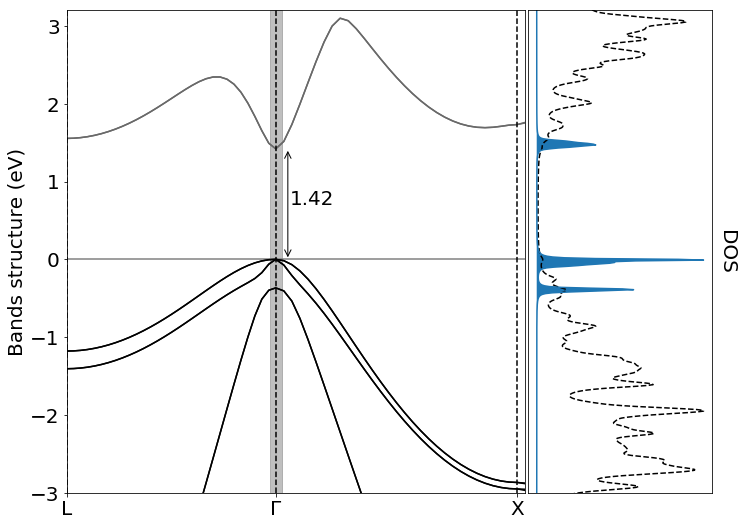

In [133]:
ymax = 3.2
ymin = -3.
label_size = 20

fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# script for the bands
path = bands.get_path()
labels,positions = bands.get_high_sym_positions()
val_bands = [2,3,4,5,6,7]
cond_bands = [8,9]
for ind in val_bands:
    ax0.plot(path,bands.bands[ind],color='black')
for ind in cond_bands:
    ax0.plot(path,bands.bands[ind],color='dimgray')
    
for pos in positions:
    ax0.axvline(pos,color='black',ls='--')
lb = []
for l in labels:
    if l == 'G': lb.append('$\Gamma$')
    else: lb.append(l)
#ax0.arrow(k0+0.1,0.,0.,1.4)
ax0.annotate('', xy=(k0+0.05, 0), xytext=(k0+0.05, 1.42), arrowprops=dict(arrowstyle='<->'),size=16)
ax0.text(k0+0.06,0.7,'1.42',size=label_size)
ax0.set_xticklabels(lb,size=label_size)
ax0.set_xticks(positions)
ax0.set_ylim(ymin,ymax)
ax0.set_xlim(0,1.9)
ax0.set_ylabel('Bands structure (eV)',size=label_size)
ax0.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
ax0.hlines(0.,0.,2,linestyles='-',color='gray')
ax0.tick_params(axis='both', which='major', labelsize=label_size)

# script for the dos
scale = max(dos.dos[0][1])
ax1.plot(dos.dos[0][1]/scale,dos.dos[0][0],linestyle='--',color='black')
scale = max(dos.dos[1][1])
ax1.plot(dos.dos[1][1]/scale,dos.dos[1][0],color='tab:blue')
ax1.fill_between(dos.dos[1][1]/scale,dos.dos[1][0], 0)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(ymin,ymax)
ax1.set_ylabel('DOS',size=label_size,rotation=270)
ax1.yaxis.set_label_coords(1.03,0.5)

plt.tight_layout(pad=-0.4)

#plt.savefig(fname='bands_dos_LGX.eps',format='eps',bbox_inches = "tight")
plt.show()

## Absorption and JDOS

We read the experimental n and k parameters and build the experimental $\epsilon_2$

In [32]:
from pandas_ods_reader import read_ods

In [27]:
abs_data = read_ods('GaAs_nk.ods', 1, columns=['energy', 'n', 'k'])

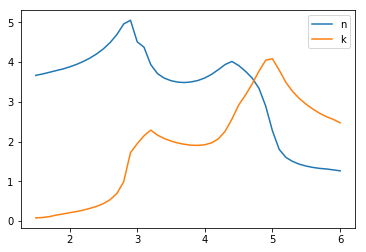

In [28]:
plt.plot(abs_data.energy,abs_data.n,label='n')
plt.plot(abs_data.energy,abs_data.k,label='k')
plt.legend()

In [30]:
energy_exp = np.array(abs_data.energy)
eps2_exp = 2.*np.array(abs_data.n)*np.array(abs_data.k)**2

In [134]:
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [135]:
weights_100 = r_100.weights

In [136]:
transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[2,3,4,5,6,7],final=[8,9])

Apply a scissor of 0.5456147497318283 eV


In [137]:
dos = U.Dos()
dos.append_fromPwData(transitions_100,weights_100,minVal=1,maxVal=3,eta=0.004,label='JDOS')

In [138]:
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field',broad_kind=U.gaussian)

In [139]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

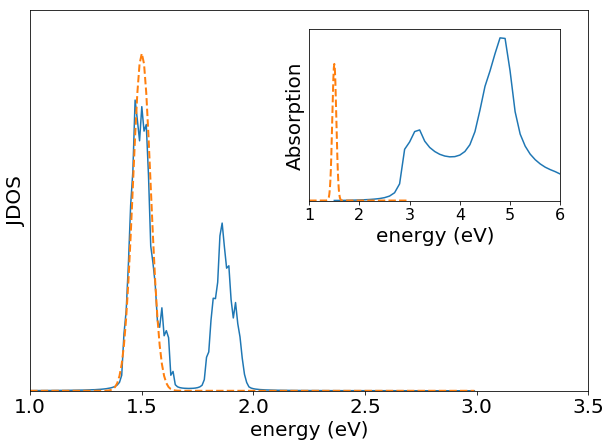

In [140]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],dos.dos[0][1], label='JDOS')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('JDOS',size=label_size)
ax1.set_xlim(1,3.5)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

## JDOS c-c' and spin splitting

In [243]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [244]:
transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


In [245]:
weights_50 = r_50.weights
weights_100 = r_100.weights

In [246]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_50,weights_50,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=50')
jdos.append_fromPwData(transitions_100,weights_100,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=100')

In [247]:
hsp = U.high_sym_fcc
bands = U.BandStructure.from_Pw('QE_bands/bands_G-K.save/data-file-schema.xml',hsp,set_gap=1.42)

Apply a scissor of 0.5446694973756367 eV


In [248]:
path = bands.get_path()
b = bands.get_bands()
spin_splitting = 1e3*(b[9]-b[8]) # in meV

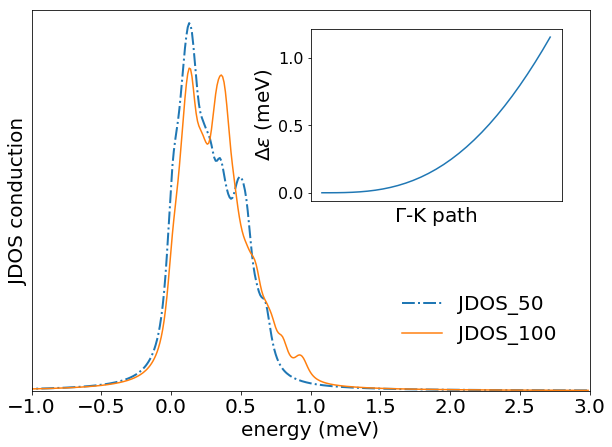

In [249]:
ymax = 2
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(jdos.dos[0][0],jdos.dos[0][1], label='JDOS_50',linestyle='-.',linewidth=2)
ax1.plot(jdos.dos[1][0],jdos.dos[1][1], label='JDOS_100')
ax1.set_xlabel('energy (meV)',size=label_size)
ax1.set_ylabel('JDOS conduction',size=label_size)
ax1.set_xlim(-1,3)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=(0.65,0.1),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(path,spin_splitting)
ax2.set_ylabel('$\Delta\epsilon$ (meV)',size=label_size)
ax2.set_xticks([])
ax2.set_xlabel('$\Gamma$-K path',size=label_size)
#ax2.set_ylim(0,100)
#ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_ccp.eps',format='eps',bbox_inches = "tight")
plt.show()

## Spin magnetization

In [226]:
path_50 = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000'
path_100 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000'
path_50_lowdeph = 'RT_k50/FixSymm/dephase_0.0001-freq_1.5-int_1000.0-simTime_10000'
path_50_longpulse = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200'

In [227]:
data_50 = P.YamboParser.from_path(path_50)
data_100 = P.YamboParser.from_path(path_100)

In [264]:
carr_50 = data_50['carriers']
carr_100 = data_100['carriers']
field_50 = data_50['external_field']
field_100 = data_100['external_field']
spin_50 = data_50['spin_magnetization']
spin_100 = data_100['spin_magnetization']

Plot of the magnetization with a low dephase in conduction

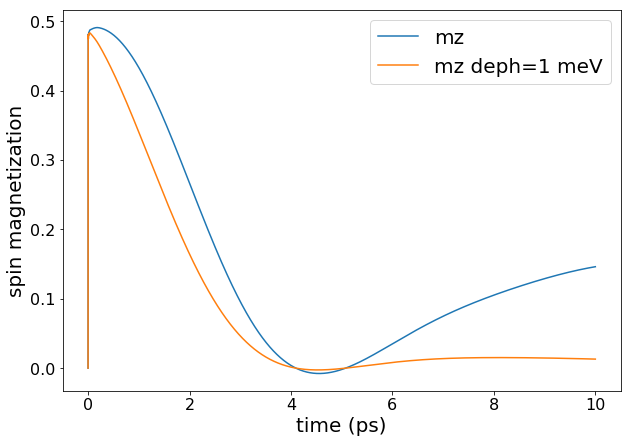

In [257]:
label_size = 20

time = spin_100['time']*1e-3 # in ps
mz = spin_100['Mc_z']
eta_cond = 1 #meV
nu = eta_cond/(U.Planck_ev_ps*1e3) # in ps

mz_deph = np.exp(-nu*time)*mz

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz,label='mz')
ax1.plot(time,mz_deph,label='mz deph=1 meV')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin magnetization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=label_size)

#plt.savefig(fname='mz_deph.eps',format='eps',bbox_inches = "tight")
plt.show()


Plot of the spin magnetization comparing differnent k samplings and insets with carriers and profile of th field

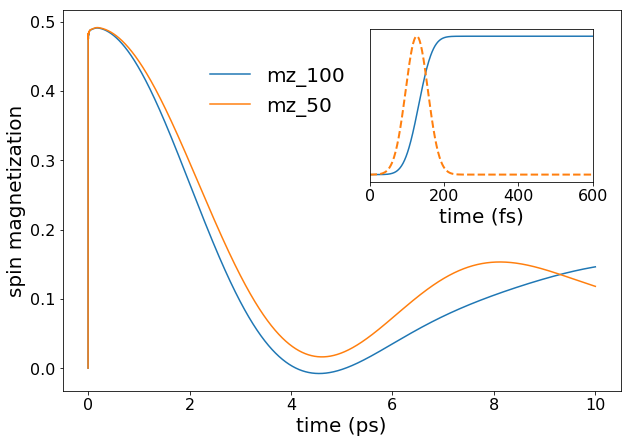

In [282]:
label_size = 20

time = spin_100['time']*1e-3 # in ps
mz_100 = spin_100['Mc_z']
mz_50 = spin_50['Mc_z']

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz_100,label='mz_100')
ax1.plot(time,mz_50,label='mz_50')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin magnetization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(loc=(0.25,.7),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.55,0.55,0.4,0.4])
ax2.set_axes_locator(ip)
ax2.plot(carr_100['time'],carr_100['dne']/(max(carr_100['dne'])))
ax2.plot(field_100['time'],field_100['Intensity']/(max(field_100['Intensity'])),linestyle='--',linewidth=2)
ax2.set_xlabel('time (fs)',size=label_size)
ax2.set_yticks([])
ax2.set_xlim(0,600)
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(fname='mz_carriers.eps',format='eps',bbox_inches = "tight")
plt.show()

In [ ]:
###############################################################################

(0, 600)

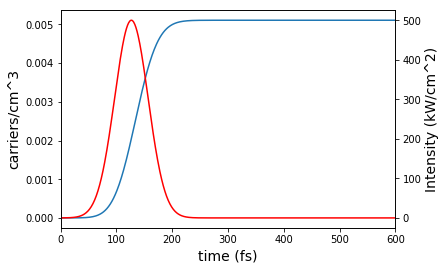

In [229]:
fig, ax1 = plt.subplots()

ax1.plot(carr_50['time'],carr_50['dne'],label='carriers')
#plt.plot(carr_100['time'],carr_100['dne'])
ax1.set_xlabel('time (fs)',size=14)
ax1.set_ylabel('carriers/cm^3',size=14)

ax2 = ax1.twinx()
ax2.plot(field_50['time'],field_50['Intensity'],label='Intensity',color='red')
ax2.set_ylabel('Intensity (kW/cm^2)',size=14)
plt.xlim(0,600)


In [384]:
spin_50 = data_50['spin_magnetization']
spin_100 = data_100['spin_magnetization']
spin_50_lowdeph = data_50_lowdeph['spin_magnetization']
spin_50_longpulse = data_50_longpulse['spin_magnetization']
#spin_100_large = data_100_large['spin_magnetization']

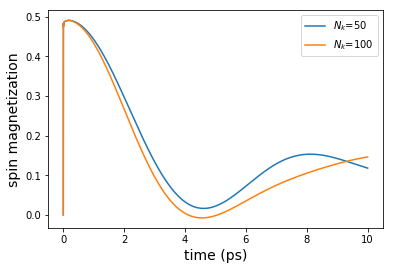

In [393]:
plt.plot(spin_50['time']*1e-3,spin_50['Mc_z'],label='$N_k$=50')
plt.plot(spin_100['time']*1e-3,spin_100['Mc_z'],label='$N_k$=100')
#plt.plot(spin_50_lowdeph['time'],spin_50_lowdeph['Mc_z'],label='50_lowdeph')
#plt.plot(spin_100_large['time'],spin_100_large['Mc_z'],label='100_large')
plt.xlabel('time (ps)',size=14)
plt.ylabel('spin magnetization',size=14)
plt.legend()

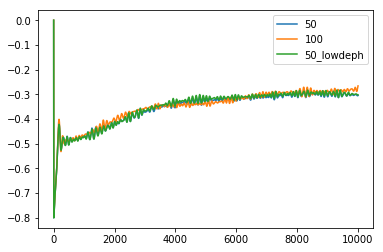

In [322]:
plt.plot(spin_50['time'],spin_50['Mv_z'],label='50')
plt.plot(spin_100['time'],spin_100['Mv_z'],label='100')
plt.plot(spin_50_lowdeph['time'],spin_50_lowdeph['Mv_z'],label='50_lowdeph')
#plt.plot(spin_100_large['time'],spin_100_large['Mv_z'],label='100')
plt.legend()

Comparison of the results with two field of different fwhm

In [337]:
field_50 = data_50['external_field']
field_50_longpulse = data_50_longpulse['external_field']

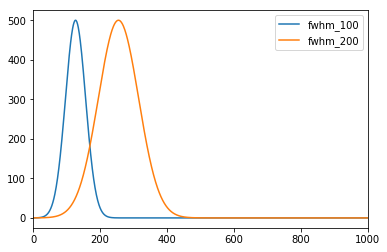

In [339]:
plt.plot(field_50['time'],field_50['Intensity'],label='fwhm_100')
plt.plot(field_50_longpulse['time'],field_50_longpulse['Intensity'],label='fwhm_200')
plt.xlim(0,1000)
plt.legend()

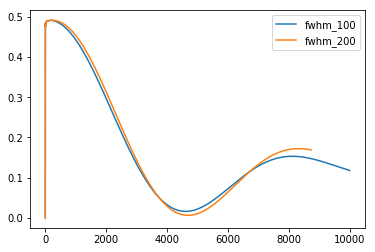

In [360]:
plt.plot(spin_50['time'],spin_50['Mc_z'],label='fwhm_100')
plt.plot(spin_50_longpulse['time'],spin_50_longpulse['Mc_z'],label='fwhm_200')

plt.legend()

## Sum of oscillatory functions

In [312]:
sim_time = 20000 # in fs
t = np.arange(0.,sim_time)

In [313]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')
r_200 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')

transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_200 = 1e3*r_200.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


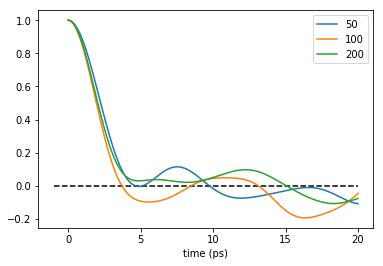

In [315]:
f_sum = 0.
for e in transitions_50:
    #print(e[0])
    nu = e[0]/(U.Planck_ev_ps*1e6)
    f_sum += np.cos(2*np.pi*nu*t)   
plt.plot(t/1000,f_sum/50,label=50)

f_sum = 0.
for e in transitions_100:
    #print(e[0])
    nu = e[0]/(U.Planck_ev_ps*1e6)
    f_sum += np.cos(2*np.pi*nu*t)
plt.plot(t/1000,f_sum/100,label=100)

f_sum = 0.
for e in transitions_200:
    #print(e[0])
    nu = e[0]/(U.Planck_ev_ps*1e6)
    f_sum += np.cos(2*np.pi*nu*t)
plt.plot(t/1000,f_sum/200,label=200)


plt.hlines(0,-1,20,linestyles='--')
plt.xlabel('time (ps)')
plt.legend()
plt.show()

__We observe a kpoint sampling induced damping in the time behavior of the magnetization.__